Running experiment with 1 node(s)...


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/19 13:18:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
                                                                                

Nodes: 1 | Data Load: 274.82s | Processing: 175.62s | Total: 450.44s
Running experiment with 2 node(s)...


Nodes: 2 | Data Load: 145.35s | Processing: 131.83s | Total: 277.18s
Running experiment with 4 node(s)...


Nodes: 4 | Data Load: 126.41s | Processing: 121.47s | Total: 247.87s


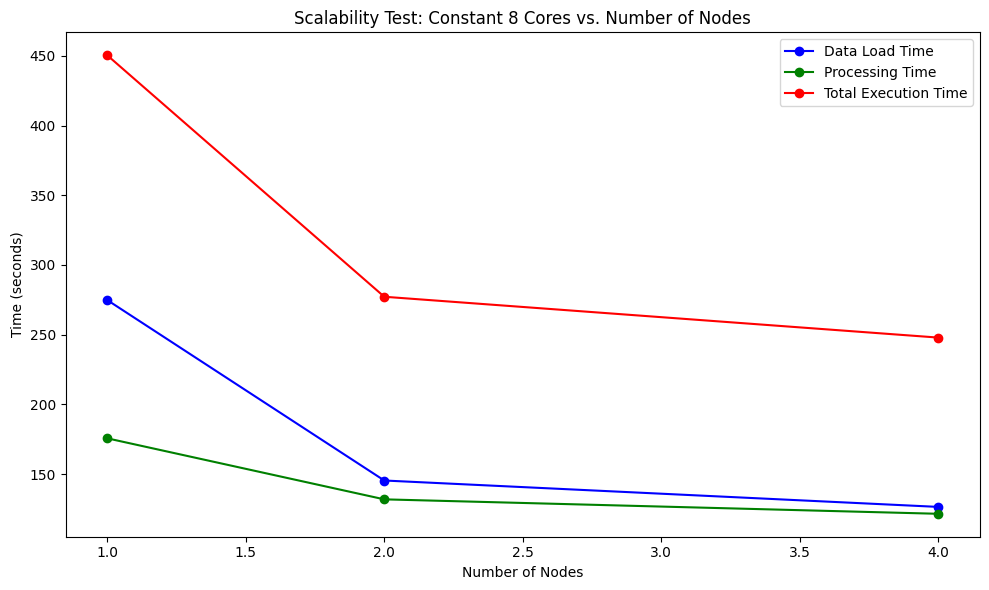

Final analysis: printing top 20 words:


25/03/19 13:37:33 ERROR DAGScheduler: Failed to update accumulator 0 (org.apache.spark.api.python.PythonAccumulatorV2) for task 2
java.net.ConnectException: Connection refused (Connection refused)
	at java.base/java.net.PlainSocketImpl.socketConnect(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.doConnect(AbstractPlainSocketImpl.java:412)
	at java.base/java.net.AbstractPlainSocketImpl.connectToAddress(AbstractPlainSocketImpl.java:255)
	at java.base/java.net.AbstractPlainSocketImpl.connect(AbstractPlainSocketImpl.java:237)
	at java.base/java.net.SocksSocketImpl.connect(SocksSocketImpl.java:392)
	at java.base/java.net.Socket.connect(Socket.java:609)
	at java.base/java.net.Socket.connect(Socket.java:558)
	at java.base/java.net.Socket.<init>(Socket.java:454)
	at java.base/java.net.Socket.<init>(Socket.java:231)
	at org.apache.spark.api.python.PythonAccumulatorV2.openSocket(PythonRDD.scala:716)
	at org.apache.spark.api.python.PythonAccumulatorV2.merge(PythonRDD.scala:738)
	at

Py4JError: An error occurred while calling o486.collectToPython

25/03/19 13:38:12 ERROR DAGScheduler: Failed to update accumulator 0 (org.apache.spark.api.python.PythonAccumulatorV2) for task 113
java.net.ConnectException: Connection refused (Connection refused)
	at java.base/java.net.PlainSocketImpl.socketConnect(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.doConnect(AbstractPlainSocketImpl.java:412)
	at java.base/java.net.AbstractPlainSocketImpl.connectToAddress(AbstractPlainSocketImpl.java:255)
	at java.base/java.net.AbstractPlainSocketImpl.connect(AbstractPlainSocketImpl.java:237)
	at java.base/java.net.SocksSocketImpl.connect(SocksSocketImpl.java:392)
	at java.base/java.net.Socket.connect(Socket.java:609)
	at java.base/java.net.Socket.connect(Socket.java:558)
	at java.base/java.net.Socket.<init>(Socket.java:454)
	at java.base/java.net.Socket.<init>(Socket.java:231)
	at org.apache.spark.api.python.PythonAccumulatorV2.openSocket(PythonRDD.scala:716)
	at org.apache.spark.api.python.PythonAccumulatorV2.merge(PythonRDD.scala:738)
	

In [1]:
import time
import re
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, explode
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import StopWordsRemover

# ----------------------------------------------------
# 1. Function to Create a Spark Session
# ----------------------------------------------------
def create_spark_session(app_name, master_url, executor_instances, executor_cores, cores_max):
    """
    This function sets up a Spark session with the given configuration.
    We use this to simulate different cluster setups.
    """
    spark = (
        SparkSession.builder
        .master(master_url)
        .appName(app_name)
        .config("spark.executor.instances", executor_instances)
        .config("spark.executor.cores", executor_cores)
        .config("spark.cores.max", cores_max)
        .getOrCreate()
    )
    return spark

# ----------------------------------------------------
# 2. Function to Clean Text
# ----------------------------------------------------
def clean_text(text):
    """
    This helper takes some text, converts it to lowercase,
    strips out any characters that aren't letters or whitespace,
    and splits it into individual words.
    """
    if text:
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text)
        return text.split()
    return []

# Register the cleaning function as a UDF so we can use it on our Spark DataFrames.
clean_text_udf = udf(clean_text, ArrayType(StringType()))

# ----------------------------------------------------
# 3. Function to Run the Analysis
# ----------------------------------------------------
def run_analysis(spark, reddit_path):
    """
    This function runs the analysis pipeline:
      1. Loads just the 'title' and 'subreddit' columns from our dataset.
      2. Figures out which 20 subreddits have the most posts.
      3. Filters the data to only include those top 20 subreddits.
      4. Cleans and tokenizes the titles, removes common stopwords,
         and counts how many times each word appears.
      5. Returns the overall time, data load time, processing time, and the DataFrame with word counts.
    """
    overall_start = time.time()

    # --- Data Loading Phase ---
    load_start = time.time()
    # Only read the columns we need to speed things up.
    df = spark.read.json(reddit_path).select("title", "subreddit")
    load_end = time.time()
    data_load_time = load_end - load_start

    # --- Find the Top 20 Subreddits ---
    # Count posts per subreddit.
    sub_count = df.groupBy("subreddit").count()
    # Get the 20 subreddits with the most posts.
    top_subreddits_df = sub_count.orderBy(F.desc("count")).limit(20)
    top_subreddits = [row["subreddit"] for row in top_subreddits_df.collect()]

    # Keep only posts from these top subreddits.
    df_top = df.filter(col("subreddit").isin(top_subreddits))

    # --- Data Processing Phase ---
    process_start = time.time()
    # Select the title column.
    df_titles = df_top.select("title")
    # Clean and tokenize the titles.
    df_titles_clean = df_titles.withColumn("cleaned_title", clean_text_udf(col("title")))
    # Remove common stopwords (like 'the', 'and', etc.).
    remover = StopWordsRemover(inputCol="cleaned_title", outputCol="filtered_words")
    df_titles_filtered = remover.transform(df_titles_clean)
    # Explode the list of words so each word is in its own row.
    df_words = df_titles_filtered.withColumn("word", explode(col("filtered_words")))
    # Count the occurrences of each word, sorted by frequency.
    df_counts = df_words.groupBy("word").count().orderBy(F.desc("count"))
    process_end = time.time()
    processing_time = process_end - load_end

    total_time = process_end - overall_start

    return total_time, data_load_time, processing_time, df_counts

# ----------------------------------------------------
# 4. Scalability Experiment and Plotting (Single Plot)
# ----------------------------------------------------
def run_experiment():
    """
    We run our analysis with different node configurations while keeping
    the total number of cores fixed at 8:
      - 1 node: 8 cores total.
      - 2 nodes: 4 cores each (8 total).
      - 4 nodes: 2 cores each (8 total).
    
    For each configuration, we measure the Data Load Time, Processing Time,
    and Total Execution Time. All three metrics are then plotted in a single chart.
    Finally, we perform one final analysis run to print the top 20 words.
    """
    master_url = "spark://192.168.2.156:7077"  # Our cluster master address.
    reddit_path = "hdfs://192.168.2.156:9000/data/reddit"  # Where our data is stored.

    # Define our node configurations with a constant total of 8 cores.
    node_configs = {
        1: (1, 8, 8),  # 1 node with 8 cores.
        2: (2, 4, 8),  # 2 nodes with 4 cores each.
        4: (4, 2, 8)   # 4 nodes with 2 cores each.
    }

    results = []
    for node_count, (instances, cores_per_executor, cores_max) in node_configs.items():
        app_name = f"Group34_{node_count}nodes"
        print(f"Running experiment with {node_count} node(s)...")
        # Create a Spark session for this configuration.
        spark = create_spark_session(app_name, master_url, instances, cores_per_executor, cores_max)
        total_time, data_load_time, processing_time, _ = run_analysis(spark, reddit_path)
        # Stop the Spark session now that we're done.
        spark.stop()

        print(f"Nodes: {node_count} | Data Load: {data_load_time:.2f}s | Processing: {processing_time:.2f}s | Total: {total_time:.2f}s")
        results.append({
            "Nodes": node_count,
            "DataLoad": data_load_time,
            "Processing": processing_time,
            "Total": total_time
        })

    # Convert our results list into a Pandas DataFrame.
    results_df = pd.DataFrame(results).sort_values("Nodes")

    # Create a single plot showing all three metrics.
    plt.figure(figsize=(10, 6))
    plt.plot(results_df["Nodes"], results_df["DataLoad"], marker="o", label="Data Load Time", color="blue")
    plt.plot(results_df["Nodes"], results_df["Processing"], marker="o", label="Processing Time", color="green")
    plt.plot(results_df["Nodes"], results_df["Total"], marker="o", label="Total Execution Time", color="red")
    plt.xlabel("Number of Nodes")
    plt.ylabel("Time (seconds)")
    plt.title("Scalability Test: Constant 8 Cores vs. Number of Nodes")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # For the final analysis, run a job using 1 node (8 cores) to print the top 20 words.
    print("Final analysis: printing top 20 words:")
    spark_final = create_spark_session("FinalRun", master_url, 1, 8, 8)
    # Run analysis and immediately convert the word counts to Pandas before stopping the session.
    _, _, _, df_counts = run_analysis(spark_final, reddit_path)
    top_words_pdf = df_counts.toPandas()  # Force evaluation while the SparkContext is still active.
    spark_final.stop()
    print(top_words_pdf.head(20))

def main():
    run_experiment()

if __name__ == "__main__":
    main()
